In [32]:
import numpy as np
import math
import sympy as sym
from scipy.integrate import ode
from scipy.io import loadmat
import scipy
from scipy import stats
import pickle
import copy
import filter_functions
from sympy.utilities.lambdify import lambdify
import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
np.set_printoptions(precision=15)
sym.init_printing()
from IPython.display import display

#MSIS: https://github.com/DeepHorizons/Python-NRLMSISE-00
#import time
from nrlmsise_00_header import *
from nrlmsise_00 import *
#SUBROUTINE GTD7D -- d[5] is the "effective total mass density
#for drag" and is the sum of the mass densities of all species
#in this model, INCLUDING anomalous oxygen.

#define constants
r_earth_const = 6378136.3 * 1e-3 #km
omega_const = 7.2921158553e-5 #rad/s, angular velocity of earth
J_2_const = .00108262617385222
J_3_const = -.00000253241051856772
mu_earth = 3.986004415e14 * 1e-9 #km^3/s^2


#Drag:
A_const = 0.9551567 * 1e-6 #km^2; cross-sectional area of satellite
m_const = 10 #kg; mass of satellite
C_D_const = 2.0
theta_dot_const = 7.2921158553e-5 #rad/sec

In [37]:

num_of_X_ensembles = 450

meas_type = 3

if meas_type == 1:
    meas_file = open('Data Files/meas_range_rangeRate.pkl', 'rb')
elif meas_type == 2:
    meas_file = open('Data Files/meas_az_el.pkl', 'rb')
elif meas_type == 3:
    meas_file = open('Data Files/meas_az_el_range_90RAAN.pkl', 'rb') #_10s_all_3stat.pkl
    
    
    
#Date of Simulation Details:
#June 24th, 2017 at 6am (this is the date & time at the beginning of the simulation/orbit)
year_init = 2017
month_init = 6
day_of_month_init = 24
day_of_year_init = 175
hour_init = 6
boulder_UT_offset = 6 #Boulder time + 6 hours = UT time
hour_init_UT = hour_init + boulder_UT_offset
    
    

#Canbera Station (DSS 34)
lat_dss34 = math.radians(-35.398333)
lon_dss34 = math.radians(148.981944)
alt_dss34 = 691.75 * 1e-3 #km

r_ecef_dss34 = filter_functions.topo2ecef(lat_dss34, lon_dss34, alt_dss34, r_earth_const)
#print(r_ecef_dss34)

#Madrid Station (DSS 65) -- correct position of Madrid Station
lat_dss65 = math.radians(40.427222)
lon_dss65 = math.radians(355.749444)
alt_dss65 = 834.539 * 1e-3 #km

r_ecef_dss65 = filter_functions.topo2ecef(lat_dss65, lon_dss65, alt_dss65, r_earth_const)
#print(r_ecef_dss65)

#Goldstone Station (DSS 13) 
lat_dss13 = math.radians(35.247164)
lon_dss13 = math.radians(200.205)
alt_dss13 = 0 #1071.14904 * 1e-3 #km

r_ecef_dss13 = filter_functions.topo2ecef(lat_dss13, lon_dss13, alt_dss13, r_earth_const)
#print(r_ecef_dss13)

#Diego Garcia, British Indian Ocean Territory 7.41173°S 72.45222°E., Space Fence (Dedicated Sensor
lat_diego = math.radians(-7.41173)
lon_diego = math.radians(72.45222)
alt_diego = 0 * 1e-3 #km, "sea level"

r_ecef_diego = filter_functions.topo2ecef(lat_diego, lon_diego, alt_diego, r_earth_const)




# read python dict containing measurements
mydict2 = pickle.load(meas_file)
meas_file.close()
measurement_array = mydict2['measurement_array']
truth_xyz = mydict2['truth_pos_vel']
true_density_array = mydict2['true_density']*1e9
lat_lst_meas_array = mydict2['lat_lst_array']
print(np.shape(measurement_array))
print(np.shape(truth_xyz))

#convert to km
truth_xyz = truth_xyz * 1e-3
measurement_array[:, -1] = measurement_array[:, -1] * 1e-3
#print(measurement_array[140,0]/(60))
#print(measurement_array[200,0]/(60)/90)



#sample measurements so only using every nth measurement
"""
truth_xyz = truth_xyz[0::20]
measurement_array = measurement_array[0::20]
true_density_array = true_density_array[0::20]
lat_lst_meas_array = lat_lst_meas_array[0::20]
print(measurement_array[50,0]/(60))
"""

print(r_ecef_diego)

(426, 5)
(426, 6)
[ 1906.947358205319915  6030.524249185401459  -822.770754462195328]


In [34]:
#read in files necessary for ensemble & density est. portion


# read python dict containing densities
ensemble_file = open('Data Files/ensemble_density_grids.pkl', 'rb')
mydict2 = pickle.load(ensemble_file)
ensemble_file.close()

#shape: ensembles (# of combos) by lat by lon
ensembles_of_density_grid = mydict2['ensemble_of_density_grids'] 
print('Shape of Vector of State/density Ensembles:', np.shape(ensembles_of_density_grid))
(num_of_ensembles, num_of_lat, num_of_lon) = np.shape(ensembles_of_density_grid)

#convert from kg/m**3 to kg/km**3 -> 1/(1e-3)**3 = 1/(1e-9) = 1e9
ensembles_of_density_grid = ensembles_of_density_grid * 1e9

latitude_grid = mydict2['latitudes'] 
longitude_grid = mydict2['longitudes'] 
lat_res = latitude_grid[1] - latitude_grid[0] #spacing between each latitude "tick"
lon_res = longitude_grid[1] - longitude_grid[0] #spacing between each longitude "tick"



#add noise w/ standard deviation = 1e-4 (used as initialization of density covariance, as well)

print(np.sum(ensembles_of_density_grid[:, 0, 0])/num_of_ensembles)
ensemble_noise = np.random.randn(num_of_ensembles, num_of_lat, num_of_lon) * 1e-4
ensembles_of_density_grid = ensembles_of_density_grid + ensemble_noise
print(np.sum(ensembles_of_density_grid[:, 0, 0])/num_of_ensembles) 


Shape of Vector of State/density Ensembles: (450, 37, 73)
0.000479211906198
0.000476386640481


In [12]:

#Propogate reference trajectory and S.T.M.
def orbitpropogator_EnKF(t, X_vector, density):
    
    ensemble_member = X_vector

    #find X acceleration via the F(X) lambdified equation
    state_acc = X_dot_sol_fcn(ensemble_member[0], ensemble_member[1], ensemble_member[2], \
                                  ensemble_member[3], ensemble_member[4], ensemble_member[5], density)
        
    dx = state_acc.flatten()
    return dx


In [13]:

#EnKF specific functionality




def gen_ensemble(X_0, Bsqrt_cov, ensemble_size):
    
    X_0 = X_0.reshape(len(X_0), 1)
    
    ensemble = np.zeros((len(X_0), ensemble_size))
    
    for ii in range(ensemble_size):
        
        member = X_0 + np.dot(Bsqrt_cov, np.random.randn(len(X_0), 1))

        ensemble[:, ii] = member.reshape(len(X_0))
    
    return ensemble
    



In [14]:
#two body motion force
# **Setup force equations/acceleration/U

#Force equations with J_2
x, y, z, J_2, r_earth, mu, r, J_3 = sym.symbols('x y z J_2 r_earth mu r J_3')


two_body_J2_string = 'mu/r * ( 1 - J_2*(r_earth/r)**2 * (3/2 * (z/r)**2 - 1/2) )' #potential
two_body_J2 = sym.sympify(two_body_J2_string)
two_body_J2 = two_body_J2.subs([(r, sym.sqrt(x**2+y**2+z**2))])
two_body_J2_acc_x = two_body_J2.diff(x)
two_body_J2_acc_y = two_body_J2.diff(y)
two_body_J2_acc_z = two_body_J2.diff(z)


two_body_J2_acc_x = two_body_J2_acc_x.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
two_body_J2_acc_y = two_body_J2_acc_y.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
two_body_J2_acc_z = two_body_J2_acc_z.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
#print('2 body & J2', two_body_J2_acc_x)

x_acc = two_body_J2_acc_x
y_acc = two_body_J2_acc_y
z_acc = two_body_J2_acc_z

In [15]:
#Add drag to J_2 force equations

x_dot, y_dot, z_dot, x_double_dot, y_double_dot, z_double_dot = \
    sym.symbols('x_dot, y_dot, z_dot, x_double_dot, y_double_dot, z_double_dot')
    
C_D, A, m, density, theta_dot, val, val_dot = \
    sym.symbols('C_D A m density theta_dot val, val_dot')

drag_str = ('-(1/2)*C_D*(A/m)*density*'
                'sqrt((x_dot+theta_dot*y)**2 + (y_dot-theta_dot*x)**2 +'
                'z_dot**2)*(val_dot+theta_dot*val)')
drag_symp = sym.sympify(drag_str)

drag_symp = drag_symp.subs([(A, A_const), (m, m_const), (C_D, C_D_const),\
                        (theta_dot, theta_dot_const)])


x_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, y), (val_dot, x_dot)])
x_acc = x_acc + x_drag_symp

y_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, x), (val_dot, y_dot)])
y_acc = y_acc + y_drag_symp

z_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, z), (val_dot, z_dot)])
z_acc = z_acc + z_drag_symp
    


x_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), x_acc)
y_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), y_acc)
z_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), z_acc)

In [16]:


if (meas_type == 1) or (meas_type == 3):
    
    x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot = \
        sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot')

    #define symbolic rho equation
    rho = ('sqrt((x - x_s)**2 + (y - y_s)**2 + (z - z_s)**2)')
    rho = sym.sympify(rho)
    #sub rotation equation of ecef for eci
    rho = rho.subs(x_s, x_sf*sym.cos(omega_const*t) - y_sf*sym.sin(omega_const*t))
    rho = rho.subs(y_s, x_sf*sym.sin(omega_const*t) + y_sf*sym.cos(omega_const*t))
    rho = rho.subs(z_s, z_sf)

    #define symbolic rho dot equation
    rho_dot = ('(x*x_dot + y*y_dot + z*z_dot - (x_dot*x_s+y_dot*y_s)*cos(theta) + \
               theta_dot*(x*x_s + y*y_s)*sin(theta) + (x_dot*y_s - y_dot*x_s)*sin(theta) +\
               theta_dot*(x*y_s - y*x_s)*cos(theta) - z_dot*z_s)/ rho')
    rho_dot = sym.sympify(rho_dot)
    #execute substitutions for rho_dot
    rho_dot = rho_dot.subs(x_s, x_sf) 
    rho_dot = rho_dot.subs(y_s, y_sf) 
    rho_dot = rho_dot.subs(z_s, z_sf) 
    rho_dot = rho_dot.subs('rho', rho)
    rho_dot = rho_dot.subs(theta, omega_const*t)    
    rho_dot = rho_dot.subs(theta_dot, omega_const)

    rho_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), rho)
    rho_dot_fcn = lambdify(((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t)), rho_dot)


if (meas_type == 2) or (meas_type == 3):
    
    #x_sf, etc. is the sensor pos in ecef
    #x, y, z is the satellite eci
    x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t = \
        sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t')
    x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
        x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega  = \
        sym.symbols('x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
        x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega')
        

    #define symbolic rho equation
    azimuth = ('atan2(x_L, y_L)') #step 4
    azimuth = sym.sympify(azimuth)
    
    elevation = ('asin(z_L/X_L_norm)') #step 4
    elevation = sym.sympify(elevation)
    elevation = elevation.subs(X_L_norm, sym.sqrt(x_L**2 + y_L**2 + z_L**2))
    
    #step 3
    azimuth = azimuth.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
            (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat))])
    elevation = elevation.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
            (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat)), \
            (z_L, x_range*sym.cos(lat)*sym.cos(lon) + y_range*sym.cos(lat)*sym.sin(lon) + z_range*sym.sin(lat))])
    
    #step 2
    azimuth = azimuth.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
            (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])
    elevation = elevation.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
            (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])
    
    #step 1
    azimuth = azimuth.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                        (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                        (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])
    elevation = elevation.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                        (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                        (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])
    
    
    azimuth = azimuth.subs([(theta, omega_const*t), (omega, omega_const)])
    elevation = elevation.subs([(theta, omega_const*t), (omega, omega_const)])
    
    azimuth_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), azimuth)
    elevation_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), elevation)
    



In [17]:
#State and A matrix


#define the symbolic state matrix
X = sym.Matrix([x, y, z, x_dot, y_dot, z_dot])
X_dot = sym.Matrix([x_dot, y_dot, z_dot, x_acc, y_acc, z_acc])
    

#partial of the force model (x dot) WRT the state vector
A_mat = X_dot.jacobian(X)
#print(A_mat)

A_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), A_mat)
#print(A_sol_fcn(1,2,3,4,5,6,7,8))

#print(X_dot)
X_dot_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), X_dot)

In [18]:
#define observation model (G) and H_tilde


if meas_type == 1:
    G = sym.Matrix([rho, rho_dot])
    
    
elif meas_type == 2:
    G = sym.Matrix([azimuth, elevation])
    
elif meas_type == 3:
    G = sym.Matrix([azimuth, elevation, rho])

#print(G)
G_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t), G)

#partial derivitive of observation model WRT the state vector
X_full = X = sym.Matrix([x, y, z, x_dot, y_dot, z_dot, density])
H_tilde = G.jacobian(X_full)
#print(H_tilde)
H_tilde_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t), H_tilde)

In [19]:



def calc_P_TU(X_mean, ensemble):
    
    P_bar_sum = np.zeros((fullState_dimension, fullState_dimension))
    
    for ii in range(num_of_X_ensembles):

        X = ensemble[:, ii].reshape(fullState_dimension, 1)
        diff_X = X - X_mean
        P_bar_sum = P_bar_sum + np.dot(diff_X, diff_X.T)

    P_bar = P_bar_sum/(num_of_X_ensembles-1)

    return P_bar



In [20]:
#define reference state at epoch, covariance at epoch, and R (using measurement noise)

pos_perturbation = 100 * 1e-3 #km
vel_perturbation = .1 * 1e-3 #km/s

density_dimension = num_of_lat * num_of_lon
prob_dimension = 6
fullState_dimension = prob_dimension + density_dimension

X_ref = np.array([truth_xyz[0,0] + pos_perturbation, truth_xyz[0,1] + pos_perturbation, truth_xyz[0,2] \
            + pos_perturbation, truth_xyz[0,3] + vel_perturbation, truth_xyz[0,4] + vel_perturbation, \
            truth_xyz[0,5] + vel_perturbation])

                  
P_sigma_pos = 100 * 1e-3 #km
P_sigma_vel = .1 * 1e-3 #km/s
P_bar_0 = np.diag([P_sigma_pos**2, P_sigma_pos**2, P_sigma_pos**2, \
                   P_sigma_vel**2, P_sigma_vel**2, P_sigma_vel**2, (1e-4)**2]) #(1e-4)**2


(L, V) = np.linalg.eig(P_bar_0[:prob_dimension, :prob_dimension]) #eigenvalues, eigenvectors
Bsqrt_cov = V * np.sqrt(L)
X_ensemble = gen_ensemble(X_ref, Bsqrt_cov, num_of_X_ensembles)
print(np.shape(X_ensemble))

       
                  
#Define Measurement Noise
if meas_type == 1:
    sigma_rho = .1 * 1e-3 #km
    sigma_rho_dot = .01 * 1e-3 #km/s
    W = np.array([[1/sigma_rho**2, 0], [0, 1/sigma_rho_dot**2]])
    R = np.linalg.inv(W)
    
elif meas_type == 2:
    arcsec_per_rad = 206264.806247 #arcsec/rad
    noise_rad = (1/arcsec_per_rad)  * 5  #5 arcsec noise (suggested by Moriba for a telescope)
    sigma_az = noise_rad
    sigma_el = noise_rad
    W = np.array([[1/sigma_az**2, 0], [0, 1/sigma_el**2]])
    R = np.linalg.inv(W)
    
elif meas_type == 3:
    arcsec_per_rad = 206264.806247 #arcsec/rad
    noise_rad = (1/arcsec_per_rad)  * 5  #5 arcsec noise (suggested by Moriba for a telescope)
    sigma_az = noise_rad
    sigma_el = noise_rad
    sigma_rho = .1 * 1e-3 #km
    W = np.array([[1/sigma_az**2, 0, 0], [0, 1/sigma_el**2, 0], [0, 0, 1/sigma_rho**2]])
    R = np.linalg.inv(W)
    
    meas_indices = np.array([0, 1, 2])

    

    
print(X_ref)

(6, 450)
[  2.596351618586980e+03   6.254794369499868e+03   1.000000000000000e-01
  -7.092719985744350e+00   2.933209216213790e+00   1.000000000000000e-04]


In [13]:
#KALMAN

def execute_enkf(obs_data, X_ensemble, P, R, density_state_ensemble,\
                         prob_dimension, density_dimension, stop_index):
    
    #initializations
    Q_ECI = np.zeros((6,6))
    
    num_of_meas = np.shape(R)[0]
    X_mean_updated = np.sum(X_ensemble, axis=1)/num_of_X_ensembles

    post_fit_list = np.zeros((stop_index, num_of_meas))

    P_list = np.zeros((stop_index, prob_dimension+1, prob_dimension+1))
    X_mean_updated_list = np.zeros((stop_index, prob_dimension+1))
    
    density_MSIS_array = np.zeros(stop_index)
    est_density_array = np.zeros(stop_index)
    #est_density_grid_array = np.zeros((stop_index, num_of_lat, num_of_lon))

    
    X_distribution = np.zeros((prob_dimension, num_of_X_ensembles, stop_index))
    density_distribution = np.zeros((num_of_ensembles, stop_index))
    lat_lst_array = np.zeros((2, stop_index))
    X_density_ensemble = np.zeros((fullState_dimension, num_of_X_ensembles))

    

    for obsnum in range(len(obs_data[:stop_index])):
        
        print(obsnum)
        
        time = obs_data[obsnum, 0]
        t_init = obs_data[obsnum-1, 0] 
        if obsnum == 0:
            t_init = obs_data[obsnum, 0]
            
        #save true MSIS density for this time step (which is density at beginning of time used to prop for this step)
        density_MSIS = filter_functions.calc_MSIS_density(time, X_mean_updated, day_of_year_init, day_of_month_init, \
                                                hour_init_UT, month_init, year_init, omega_const, r_earth_const)
        density_MSIS = density_MSIS * 1e9  #convert from kg/m**3 to kg/km**3
        density_MSIS_array[obsnum] = density_MSIS
        
        
        #determine density to be used in propagation
        (lat_grid_ticks, lst_grid_ticks) = filter_functions.calc_lat_lst_indices(t_init, \
                            X_mean_updated[:3].reshape(3,1), day_of_month_init, hour_init_UT, month_init, \
                                   year_init, omega_const, r_earth_const, lat_res, lon_res)
        
        latt = np.degrees(latitude_grid[lat_grid_ticks])
        lonn = np.degrees(longitude_grid[lst_grid_ticks])
        
        lat_meas = lat_lst_meas_array[obsnum-1, 0]
        lon_meas = lat_lst_meas_array[obsnum-1, 1]
        
        densities = density_state_ensemble[:, lat_grid_ticks, lst_grid_ticks]


        result = X_ensemble

        if (obs_data[obsnum, 0] != obs_data[obsnum-1, 0]) and (obsnum != 0):
            
            result = np.zeros((prob_dimension, num_of_X_ensembles))

            for ii in range(num_of_X_ensembles):
                #set the initial values for the propogator:
                y0 = X_ensemble[:, ii]
                density = densities[ii]
            
                integrator = ode(orbitpropogator_EnKF)
                integrator.set_integrator('dopri5', nsteps=1e6, rtol=1e-12, atol=1e-12)
                integrator.set_f_params(density)
                integrator.set_initial_value(y0, t_init)
                integrator.integrate(time)
                result[:, ii] = integrator.y

        X_ensemble = result.reshape(prob_dimension, num_of_X_ensembles)
        
        
        #create array that holds X state ensemble & density state ensemble combined
        density_state = density_state_ensemble[:, lat_grid_ticks, lst_grid_ticks]
        X_density_ensemble[:6, :] = X_ensemble
        X_density_ensemble[6:, :] = density_state_ensemble.reshape(num_of_ensembles, density_dimension).T 
        #****density_state
        
        #mean of X state & density state over ensemble
        X_bar = np.sum(X_density_ensemble, axis=1).reshape(fullState_dimension,1)/num_of_X_ensembles
        
        #calculate Time Updated P
        P_TU = calc_P_TU(X_bar, X_density_ensemble)
        
        
        
        #determine station coordinates for observation eq.
        if int(obs_data[obsnum, 1]) == 1:
            #print('1')
            station_index = 0
            X_s = r_ecef_dss34
        if int(obs_data[obsnum, 1]) == 2:
            #print('2')
            station_index = 1
            X_s = r_ecef_dss65
        if int(obs_data[obsnum, 1]) == 3:
            #print('3')
            station_index = 2
            X_s = r_ecef_dss13
        if int(obs_data[obsnum, 1]) == 4:
            #print('amos')
            station_index = 3
            X_s = r_ecef_diego

        
        #-------------------Measurement Update--------------------------------------------------------
        
        #-----calculate Hx_bar (predicted measurement for each member)-----
        Hx_array = np.zeros((num_of_meas, num_of_X_ensembles))
        Hx = np.zeros(3)

        for ii in range(num_of_X_ensembles):
            
            X = X_ensemble[:, ii]

            Hx = G_sol_fcn(*X, *X_s, time)
            
            if (meas_type != 1) and (Hx[0] < 0): #if az less than 0, add 2*pi
                Hx[0] = Hx[0] + 2*math.pi

            Hx_array[:, ii] = Hx.reshape(num_of_meas)
            
        
        Hx_bar = np.sum(Hx_array, axis=1).reshape(num_of_meas,1)/num_of_X_ensembles #mean of Hx over ensemble
         
        
        
        #------------------calculate Pyy & Pxy-------------------
        Pyy_sum = np.zeros((num_of_meas, num_of_meas))
        Pxy_sum = np.zeros((fullState_dimension, num_of_meas))
        
        for ii in range(num_of_X_ensembles):
        
            #Pyy
            diff_Hx = Hx_array[:, ii].reshape(num_of_meas, 1) - Hx_bar
            Pyy_sum = Pyy_sum + np.dot(diff_Hx, diff_Hx.T)

            #Pxy
            X = X_density_ensemble[:, ii].reshape(fullState_dimension, 1)
            diff_X = X - X_bar
            Pxy_sum = Pxy_sum + np.dot(diff_X, diff_Hx.T)
          
       
        Pyy_term = Pyy_sum/(num_of_X_ensembles-1)
        Pyy = Pyy_term + R
        Pxy = Pxy_sum/(num_of_X_ensembles-1)

        
        #--------calculate Kalman gain & apply measurement for posterior estimate------
        K = np.dot(Pxy, np.linalg.inv(Pyy))
        
        #get actual observation
        y_observed = obs_data[obsnum, 2:(2+num_of_meas)].reshape(num_of_meas,1)

        X_density_ensemble_updated = np.zeros((fullState_dimension, num_of_X_ensembles))
        #**correction_array = np.zeros((1, num_of_X_ensembles))
        for ii in range(num_of_X_ensembles):
            
            e = np.sqrt(np.diag(R)).reshape(num_of_meas, 1) * np.random.randn(num_of_meas, 1)
            
            correction = np.dot(K, (y_observed + e - Hx_array[:, ii].reshape(num_of_meas, 1)))
            
            X_member_updated = X_density_ensemble[:, ii].reshape(fullState_dimension, 1) + correction
                
            X_density_ensemble_updated[:, ii] = X_member_updated.reshape(fullState_dimension)
            #**correction_array[:, ii] = correction[-1,0] #save density correction
        
        
        #update overall density grid ensemble with this lat/lon's updated density values 
        updated_density_portion = X_density_ensemble_updated[6:,:].T.reshape(num_of_ensembles, num_of_lat, num_of_lon)
        density_state_ensemble = copy.deepcopy(updated_density_portion) #**X_density_ensemble_updated[-1,:]
        #**density_state_ensemble[:, lat_grid_ticks, lst_grid_ticks]
        #est_density_grid_array[obsnum] = np.mean(density_state_ensemble, axis=0)
        
        
        #apply update to local lat/lst combos via localization
        #**density_state_ensemble = localization(lat_grid_ticks, lst_grid_ticks, \
                #correction_array, density_state_ensemble)

        
        est_density_array[obsnum] = np.sum(updated_density_portion[:, lat_grid_ticks, lst_grid_ticks])\
                                                                                            /num_of_ensembles
        #**np.sum(X_density_ensemble_updated[-1,:])/num_of_ensembles
            
        #save values
        X_mean_updated = np.zeros((7))
        X_mean_updated[:6] = np.sum(X_density_ensemble_updated[:6,:], axis=1)/num_of_X_ensembles
        X_mean_updated[6:] = est_density_array[obsnum]
        #**X_mean_updated = np.sum(X_density_ensemble_updated, axis=1)/num_of_X_ensembles
        X_mean_updated_list[obsnum, :] = X_mean_updated
        
        #save values for analysis of distributions and such
        density_distribution[:, obsnum] = updated_density_portion[:, lat_grid_ticks, lst_grid_ticks] 
        #**X_density_ensemble_updated[-1,:]
        X_distribution[:, :, obsnum] = X_density_ensemble_updated[:6, :]
        lat_lst_array[:, obsnum] = np.array([latitude_grid[lat_grid_ticks], longitude_grid[lst_grid_ticks]]).reshape(2)

        
        #book:
        #P = P_TU - np.dot(K, np.dot(Pyy, K.T)) 
        #Tracer() ()
        #if obsnum > 5:
        #print('cor:', np.diag(np.dot(K, np.dot(Pyy, K.T)))[:3])
        #print('P:', np.diag(P)[:3])
        
        
        #Review, eq. 9:
        #pad H with zeros for density portion of state b/c partial of meas WRT to density = 0
        H = np.zeros((num_of_meas, fullState_dimension))
        H[:num_of_meas, :prob_dimension+1] = H_tilde_sol_fcn(*X_mean_updated[:6], *X_s, time)
        part1 = np.identity(fullState_dimension) - np.dot(K, H)
        P = np.dot(part1, np.dot(P_TU, part1.T)) + np.dot(K, np.dot(R, K.T))
        
        #Review, eq. 10:
        #P = np.dot((np.identity(prob_dimension+1) - np.dot(K, H)), P_TU)
        
        P_list[obsnum, :6, :6] = P[:6, :6]
        P_list[obsnum, -1, -1] = P[0,6:].reshape(num_of_lat, num_of_lon)[lat_grid_ticks, lst_grid_ticks]


        #-------------RMS / Residuals-------------
        Hx = G_sol_fcn(*X_mean_updated[:6], *X_s, time)
        if Hx[0] < 0:
            Hx[0] = Hx[0] + 2*math.pi
        post_fit_resid = y_observed - Hx.reshape(num_of_meas, 1)
        post_fit_list[obsnum, :] = post_fit_resid.reshape(num_of_meas) 
        

        #Prep for next time step
        X_ensemble = X_density_ensemble_updated[:6, :]

    
    
    return (X_mean_updated_list, P_list, post_fit_list, density_MSIS_array, est_density_array, X_distribution, \
            density_distribution, lat_lst_array, updated_density_portion, X_ensemble)#, est_density_grid_array)

In [14]:
#Call EnKF


stop_index = 20 #558 * 3 #92.56 minutes #len(measurement_array)/2

(X_mean_updated_list_EnKF, P_list_EnKF, post_fit_list_EnKF, density_MSIS_array, est_density_array,\
X_distribution, density_distribution, lat_lst_array, updated_density_portion, X_ensemble) = \
            execute_enkf(measurement_array, X_ensemble, P_bar_0, R, ensembles_of_density_grid,\
                         prob_dimension, density_dimension, stop_index)
    
    #, est_density_grid_array) = \

0


KeyboardInterrupt: 

In [15]:
#Save Results

"""

#generate density grid for final time in order to compare entire final density grid estimate to truth
alt = np.linalg.norm(X_mean_updated_list_EnKF[-1,:3]) - r_earth_const
print(alt)
final_density_grid_truth = filter_functions.gen_one_ensemble(latitude_grid, longitude_grid, alt,\
                                                    day_of_year_init, measurement_array[stop_index-1,0]) #final time

final_density_grid_truth_timeSeries = np.zeros((stop_index, num_of_lat, num_of_lon))

for ii in range(stop_index):
    
    #generate density grid for final time in order to compare entire final density grid estimate to truth
    alt = np.linalg.norm(X_mean_updated_list_EnKF[ii,:3]) - r_earth_const
    final_density_grid_truth_timeSeries[ii] = filter_functions.gen_one_ensemble(latitude_grid, longitude_grid, alt,\
                                                day_of_year_init, measurement_array[ii,0]) #final time
    



#PKL file

mydict = {'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
          'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
          'est_density_array': est_density_array, 'X_distribution': X_distribution, \
          'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
         'final_density_ensemble_est': updated_density_portion, 'final_X_ensemble': X_ensemble,\
        'true_density_array': true_density_array*1e9, \
          'final_density_grid_truth_timeSeries': final_density_grid_truth_timeSeries*1e9,
         'est_density_grid_array': est_density_grid_array}

output = open('Figures/Results.pkl', 'wb')
pickle.dump(mydict, output)
output.close()



#MATLAB file

filename = 'Data Files/7Period_Results.mat'

import scipy.io
scipy.io.savemat(filename, mdict={'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
          'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
          'est_density_array': est_density_array, 'X_distribution': X_distribution, \
          'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
         'final_density_ensemble_est': updated_density_portion, 'final_X_ensemble': final_X_ensemble,
        'true_density_array': true_density_array*1e9, 
        'final_density_grid_truth_timeSeries': final_density_grid_truth_timeSeries*1e9,
        'est_density_grid_array': est_density_grid_array})

"""


"\n\n#generate density grid for final time in order to compare entire final density grid estimate to truth\nalt = np.linalg.norm(X_mean_updated_list_EnKF[-1,:3]) - r_earth_const\nprint(alt)\nfinal_density_grid_truth = filter_functions.gen_one_ensemble(latitude_grid, longitude_grid, alt,                                                    day_of_year_init, measurement_array[stop_index-1,0]) #final time\n\nfinal_density_grid_truth_timeSeries = np.zeros((stop_index, num_of_lat, num_of_lon))\n\nfor ii in range(stop_index):\n    \n    #generate density grid for final time in order to compare entire final density grid estimate to truth\n    alt = np.linalg.norm(X_mean_updated_list_EnKF[ii,:3]) - r_earth_const\n    final_density_grid_truth_timeSeries[ii] = filter_functions.gen_one_ensemble(latitude_grid, longitude_grid, alt,                                                day_of_year_init, measurement_array[ii,0]) #final time\n    \n\n\n\n#PKL file\n\nmydict = {'X_mean_updated_list_EnKF': X_mea

In [35]:
#Read Data (from saved run) in to Generate Results

#"""

# read python dict containing densities
results_file = open('Figures/7Periods_trulyObs_0RAAN/Results.pkl', 'rb') #Results_1Period/Results_558.pkl
mydict = pickle.load(results_file)
results_file.close()

X_mean_updated_list_EnKF = mydict['X_mean_updated_list_EnKF'] 
P_list_EnKF = mydict['P_list_EnKF'] 
post_fit_list_EnKF = mydict['post_fit_list_EnKF'] 
density_MSIS_array = mydict['density_MSIS_array'] 
est_density_array = mydict['est_density_array'] 
X_distribution = mydict['X_distribution'] 
density_distribution = mydict['density_distribution'] 
lat_lst_array = mydict['lat_lst_array']
final_density_ensemble_est = mydict['final_density_ensemble_est']
final_X_ensemble = mydict['final_X_ensemble']
#true_density_array = mydict['true_density_array']
final_density_grid_truth_timeSeries = mydict['final_density_grid_truth_timeSeries']
est_density_grid_array = mydict['est_density_grid_array']

"""

mydict = {'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
              'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
              'est_density_array': est_density_array, 'X_distribution': X_distribution, \
              'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
             'final_density_ensemble_est': final_density_ensemble_est, 'final_X_ensemble': final_X_ensemble,\
            'true_density_array': true_density_array, \
              'final_density_grid_truth_timeSeries': final_density_grid_truth_timeSeries,
             'est_density_grid_array': est_density_grid_array}

output = open('Figures/Results.pkl', 'wb')
pickle.dump(mydict, output)
output.close()



filename = 'Data Files/Results.mat'

import scipy.io
scipy.io.savemat(filename, mdict={'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
          'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
          'est_density_array': est_density_array, 'X_distribution': X_distribution, \
          'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
         'final_density_ensemble_est': final_density_ensemble_est, 'final_X_ensemble': final_X_ensemble,
        'true_density_array': true_density_array, 
        'final_density_grid_truth_timeSeries': final_density_grid_truth_timeSeries,
        'est_density_grid_array': est_density_grid_array})
                
"""


print(final_density_grid_truth_timeSeries[:10,0, 0])
print(est_density_array[:10])
print(true_density_array[:10])

[ 0.000636672171598  0.000637674040385  0.000638987034044
  0.000640175951719  0.000641463257098  0.000642637871838
  0.000643728347918  0.000644913650855  0.000646126477     0.000647263245177]
[ 0.000726076118282  0.000726499374273  0.000727041154841
  0.000728036819823  0.000727063680281  0.00084248893537   0.000835295833113
  0.000836326686395  0.000839133606831  0.000834723597215]
[ 0.001060942112722  0.00106711154152   0.001073321258419
  0.001079570588597  0.001085858789703  0.001092185051341
  0.001098548494694  0.001104948172113  0.001111383066828  0.0011178520927  ]


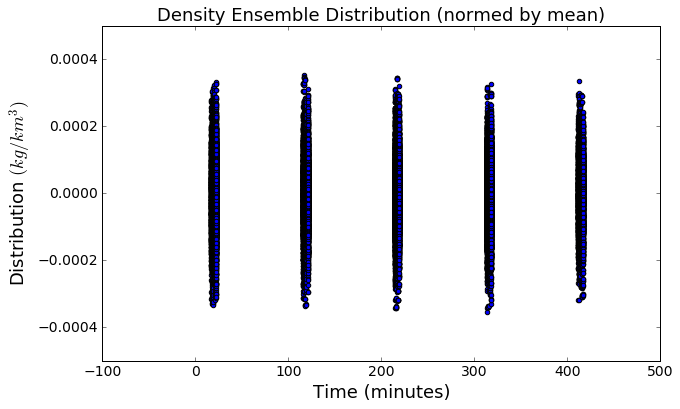

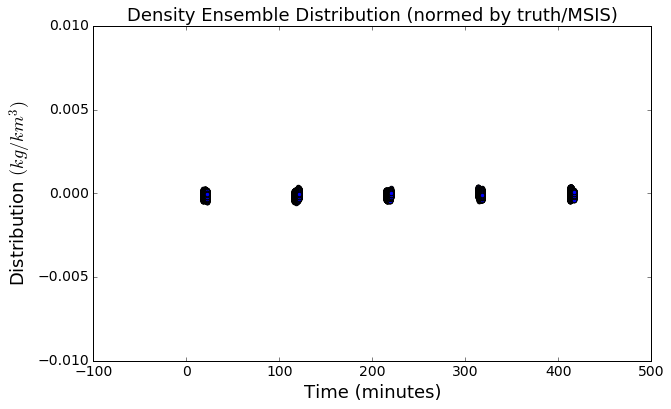

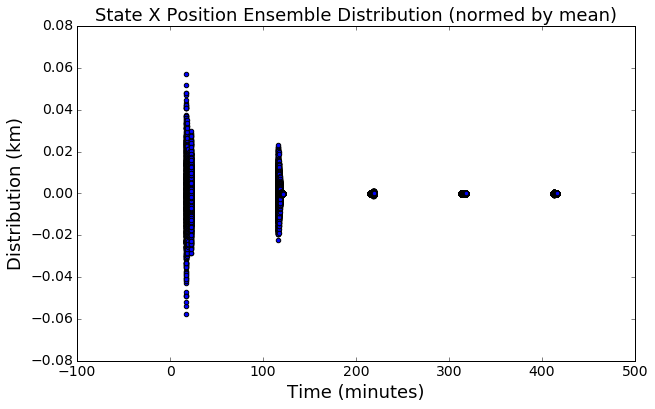

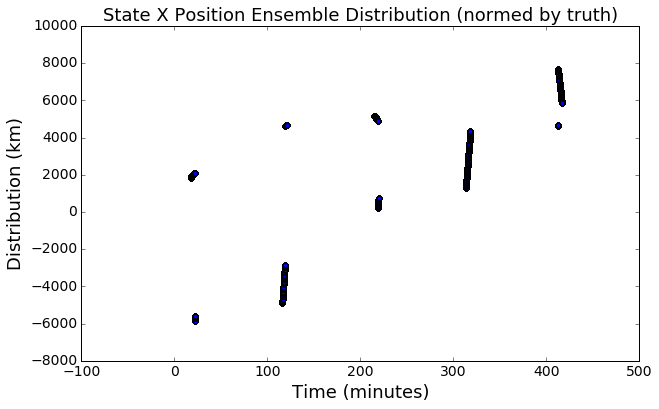

In [22]:

stop_index = 150



times = measurement_array[:stop_index, 0]/(60)

time_str = 'Time (minutes)'

time_repeated_ensemble = np.repeat(times[:stop_index], num_of_ensembles)
time_repeated_X = np.repeat(times[:stop_index], num_of_X_ensembles)

#"""
#calculate the normed density distribution by subtracting the mean of the ensemble from each ensemble   
#density_distribution shape = num_of_ensembles x stop_index
density_distribution_mean = np.mean(density_distribution[:,:stop_index], axis=0).reshape(1, stop_index)

density_distribution_mean_tiled = np.tile(density_distribution_mean, (1, num_of_X_ensembles))
density_distribution_mean_tiled = density_distribution_mean_tiled.reshape(num_of_X_ensembles, stop_index)

density_distribution_normed = density_distribution[:, :stop_index] - density_distribution_mean_tiled

fig = plt.figure()
plt.scatter(time_repeated_ensemble, density_distribution_normed.T.flatten())
plt.ylabel(r'Distribution $(kg/km^3)$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim(-.5e-3, .5e-3)
plt.title('Density Ensemble Distribution (normed by mean)', fontsize=18)
plt.show()



#calculate the normed density distribution by subtracting the truth of the ensemble from each ensemble   
#density_distribution shape = num_of_ensembles x stop_index
density_distribution_truth = density_MSIS_array[:stop_index].reshape(1, stop_index)
density_distribution_normed = density_distribution[:, :stop_index] - \
                    np.tile(density_distribution_truth, (num_of_ensembles, 1))

fig = plt.figure()
plt.scatter(time_repeated_ensemble, density_distribution_normed.T.flatten())
plt.ylabel(r'Distribution $(kg/km^3)$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim(-1e-2, 1e-2)
plt.title('Density Ensemble Distribution (normed by truth/MSIS)', fontsize=18)
plt.show()
#"""

#calculate the normed X pos distribution by subtracting the mean of the ensemble from each ensemble   
#X_distribution shape = 6 x num_of_X_ensembles x stop_index
X_distribution_Xpos = X_distribution[0,:,:stop_index]
X_distribution_Xpos_mean = np.mean(X_distribution_Xpos, axis=0).reshape(1, stop_index)
X_distribution_Xpos_mean_tiled = np.tile(X_distribution_Xpos_mean, (1, num_of_X_ensembles))
X_distribution_Xpos_mean_tiled = X_distribution_Xpos_mean_tiled.reshape(num_of_X_ensembles, stop_index)
X_distribution_Xpos_diff = X_distribution_Xpos - X_distribution_Xpos_mean_tiled

fig = plt.figure()
plt.scatter(time_repeated_X, X_distribution_Xpos_diff.T.flatten())
plt.ylabel(r'Distribution (km)', fontsize=18)
plt.xlabel(time_str, fontsize=18)
#plt.ylim(-1e-4,1e-4)
plt.title('State X Position Ensemble Distribution (normed by mean)', fontsize=18)
plt.show()



#calculate the normed X pos distribution by subtracting the truth of the ensemble from each ensemble   
#X_distribution shape = 6 x num_of_X_ensembles x stop_index
X_distribution_Xpos_truth = truth_xyz[:stop_index, 0].reshape(1, stop_index)
X_distribution_Xpos_truth_normed = X_distribution_Xpos - np.tile(X_distribution_Xpos_truth, (num_of_ensembles, 1))

fig = plt.figure()
plt.scatter(time_repeated_ensemble, X_distribution_Xpos_truth_normed.T.flatten())
plt.ylabel(r'Distribution (km)', fontsize=18)
plt.xlabel(time_str, fontsize=18)
#plt.ylim(-1e-4, 1e-4)
plt.title('State X Position Ensemble Distribution (normed by truth)', fontsize=18)
plt.show()



In [36]:



#print(np.degrees(lat_lst_meas_array[:stop_index, 0]))
#print(np.degrees(lat_lst_meas_array[:stop_index, 0])- np.degrees(lat_lst_array[0,:stop_index]))
#print(np.shape(lat_lst_array))



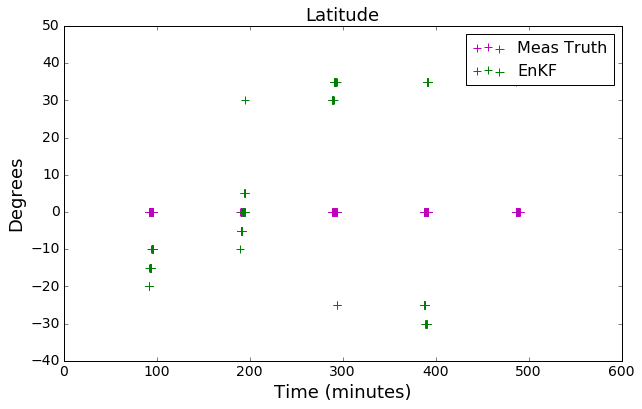

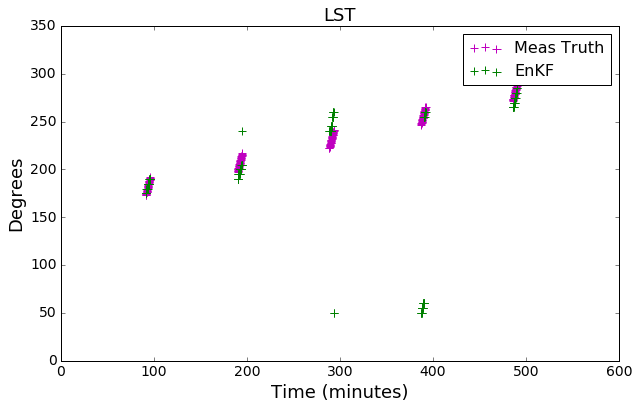

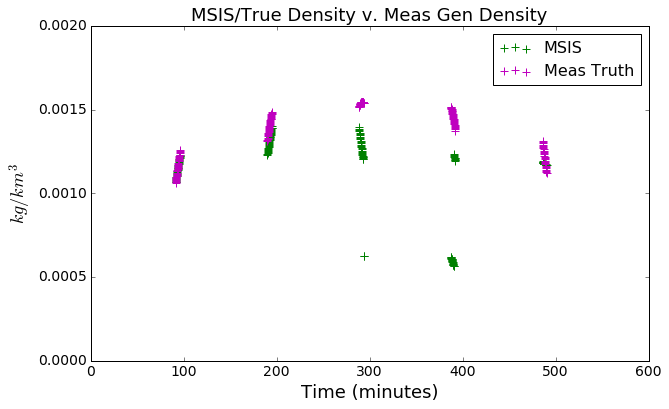

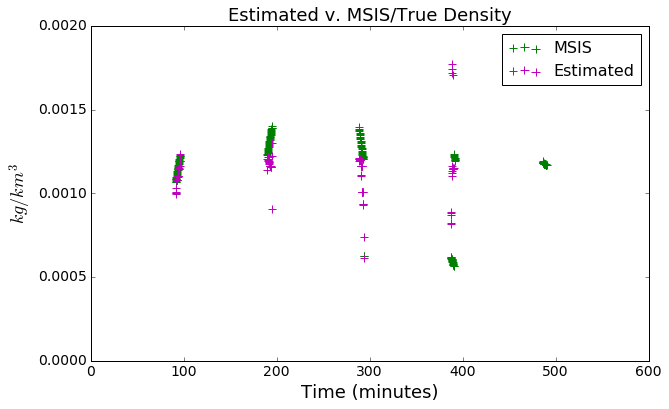

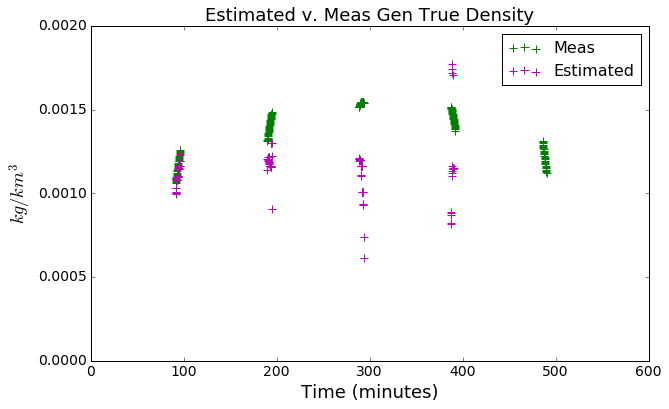

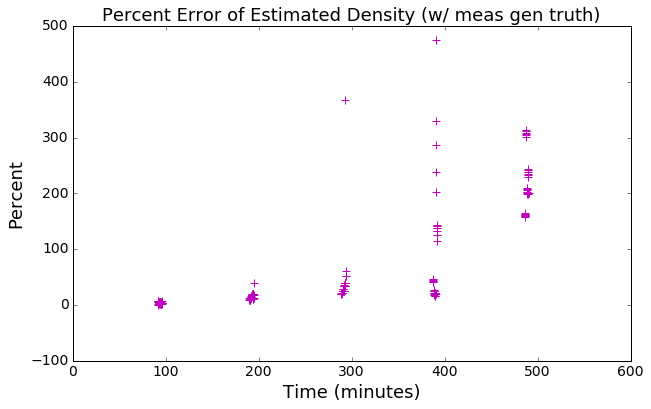

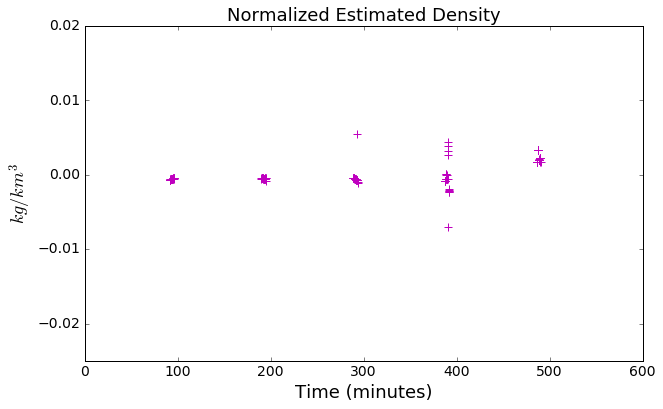

In [30]:
#stop_index = 10


times = measurement_array[:stop_index, 0]/(60)

time_repeated_ensemble = np.repeat(times[:stop_index], num_of_ensembles)
time_repeated_X = np.repeat(times[:stop_index], num_of_X_ensembles)


fig_lat = plt.figure()
plt.scatter(times, np.degrees(lat_lst_meas_array[:stop_index, 0]), s=70, c='m',marker='+')
plt.scatter(times, np.degrees(lat_lst_array[0,:stop_index]), s=70, c='g',marker='+')
plt.ylabel('Degrees', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.title('Latitude', fontsize=18)
legend_names = ['Meas Truth', 'EnKF']
plt.legend(legend_names, fontsize=16)
plt.show()



fig_LST = plt.figure()
plt.scatter(times, np.degrees(lat_lst_meas_array[:stop_index, 1]), s=70, c='m', marker='+')
plt.scatter(times, np.degrees(lat_lst_array[1,:stop_index]), s=70, c='g', marker='+')
plt.ylabel('Degrees', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.title('LST', fontsize=18)
legend_names = ['Meas Truth', 'EnKF']
plt.legend(legend_names, fontsize=16)
plt.show()


fig_density_comparison = plt.figure()
plt.scatter(times, density_MSIS_array[:stop_index], s=70, c='g', marker='+')
plt.scatter(times, true_density_array[:stop_index], s=70, c='m', marker='+')
#plt.ylim([-1e-11,1e-11])
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim([0,2e-3])
plt.title('MSIS/True Density v. Meas Gen Density', fontsize=18)
legend_names = ['MSIS', 'Meas Truth']
plt.legend(legend_names, fontsize=16)
plt.show()


fig_density_comparison = plt.figure()
plt.scatter(times, density_MSIS_array[:stop_index], s=70, c='g', marker='+')
plt.scatter(times, est_density_array[:stop_index], s=70, c='m', marker='+')
#plt.ylim([-1e-11,1e-11])
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim([0,2e-3])
plt.title('Estimated v. MSIS/True Density', fontsize=18)
legend_names = ['MSIS', 'Estimated']
plt.legend(legend_names, fontsize=16)
plt.show()




fig_density_comparison = plt.figure()
plt.scatter(times, true_density_array[:stop_index], s=70, c='g', marker='+')
plt.scatter(times, est_density_array[:stop_index], s=70, c='m', marker='+')
#plt.ylim([-1e-11,1e-11])
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim([0,2e-3])
plt.title('Estimated v. Meas Gen True Density', fontsize=18)
legend_names = ['Meas', 'Estimated']
plt.legend(legend_names, fontsize=16)
plt.show()


perc_error = 100 * np.absolute(est_density_array[:stop_index] - true_density_array[:stop_index])/true_density_array[:stop_index]

fig_percent = plt.figure()
plt.scatter(times, perc_error[:stop_index], s=70, c='m', marker='+')
#plt.ylim([-1e-11,1e-11])
plt.ylabel('Percent', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.title('Percent Error of Estimated Density (w/ meas gen truth)', fontsize=18)
plt.show()



mean = np.mean(est_density_array[:stop_index])
est_density_array_normalized = est_density_array[:stop_index] - mean

fig_est = plt.figure()
plt.scatter(times, est_density_array_normalized[:stop_index], s=70, c='m', marker='+')
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.title('Normalized Estimated Density', fontsize=18)
plt.show()


#"""
fig_lat.savefig('Figures/latitude.png')
fig_LST.savefig('Figures/LST.png')
fig_density_comparison.savefig('Figures/density_comparison.png')
fig_percent.savefig('Figures/percent.png')
fig_est.savefig('Figures/est_density.png')
#"""

[ 168.666666666666657  547.333333333333371  547.5              ]


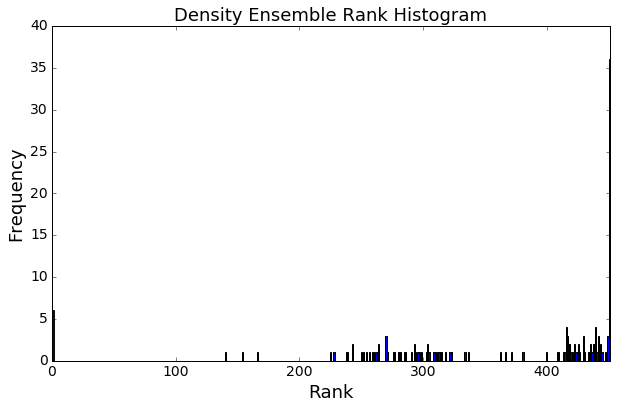

In [38]:
# Rank Histograms


#Density

rank_array = np.zeros((stop_index, 1))

for ii in range(stop_index):
    
    new_array = np.append(density_distribution[:, ii], density_MSIS_array[ii])
    
    rank = scipy.stats.rankdata(new_array, method='min')[-1]
    
    rank_array[ii] = rank
    
indices = np.where(rank_array != 450)[0]
indices1 = np.where(rank_array == 450)[0]
print(times[indices1])


fig_rank_hist = plt.figure()
plt.hist(rank_array, bins=451)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Rank', fontsize=18)
plt.title('Density Ensemble Rank Histogram', fontsize=18)
plt.xlim([0,451])
plt.show()

#fig_rank_hist.savefig('Figures/rank_hist.png')




Post-fit RMS:
Azimuth = 0.00130100566412 degrees
Elevation = 0.00146182811772 degrees
Range = 8.76865181695e-05 km


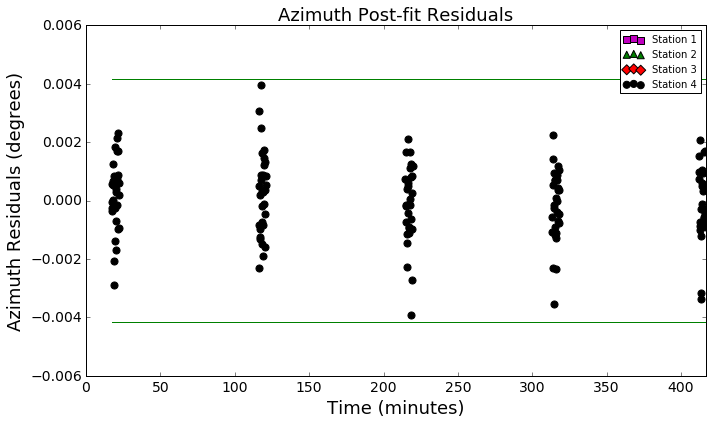

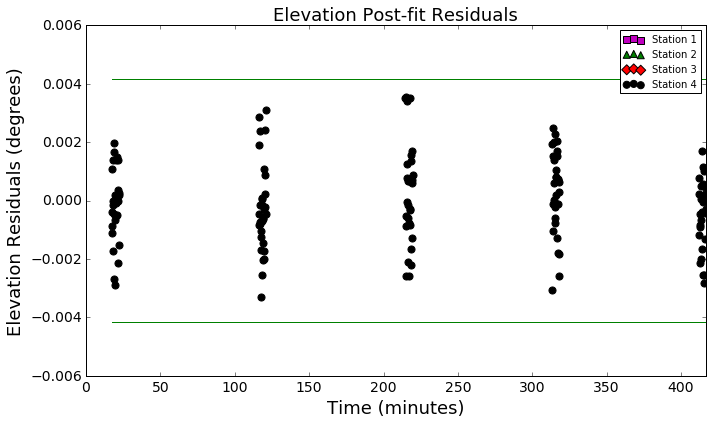

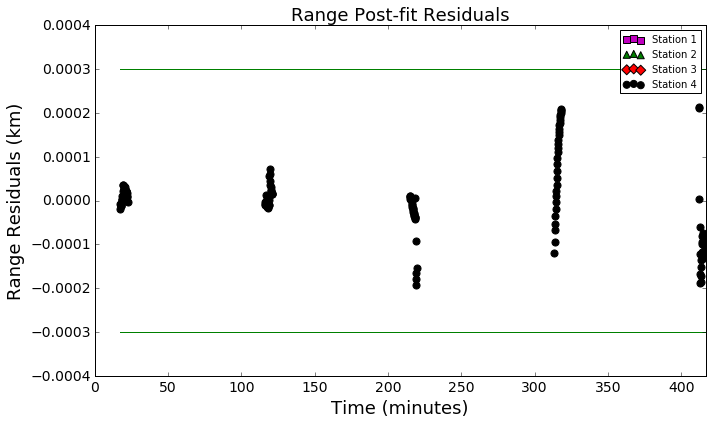

Density RMS = 0.000844251305251 $(kg/km^3)$
Position RMS:
X = 4409.66959518 km
Y = 5920.53293778 km
Z = 3903.85942554 km
Overall = 8350.92896751 km


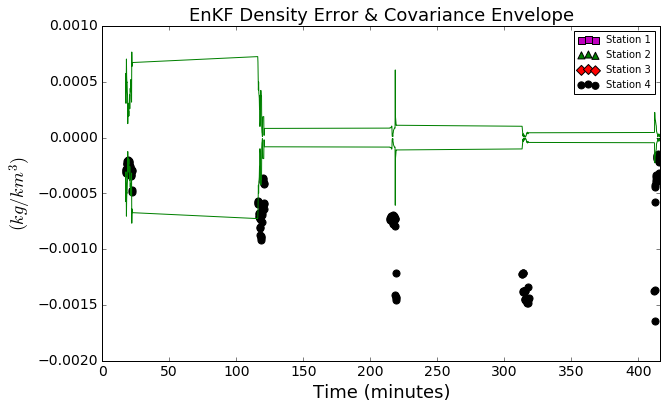

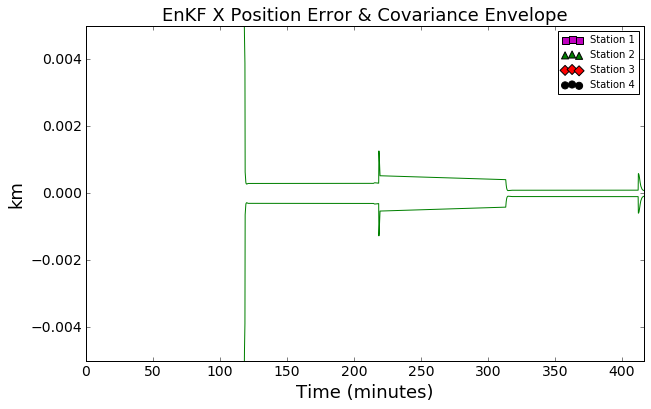

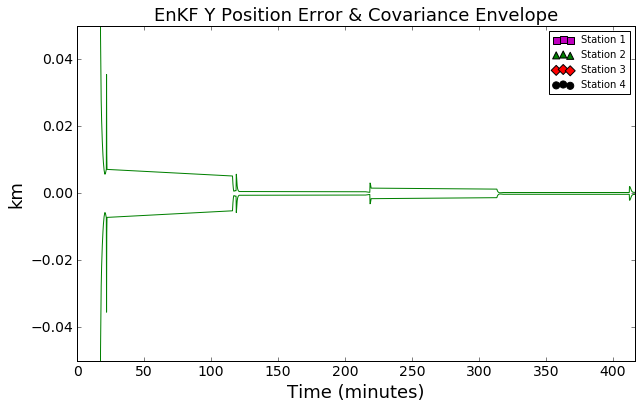

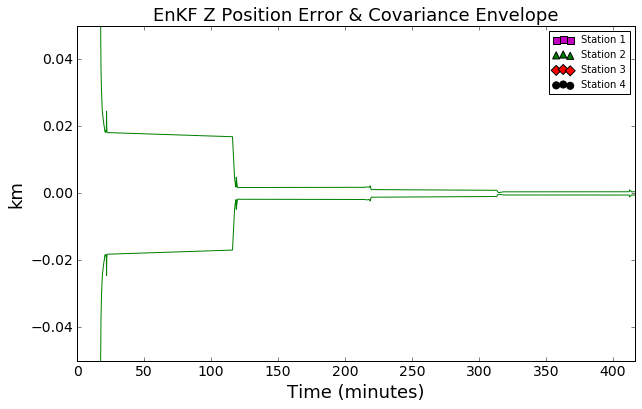

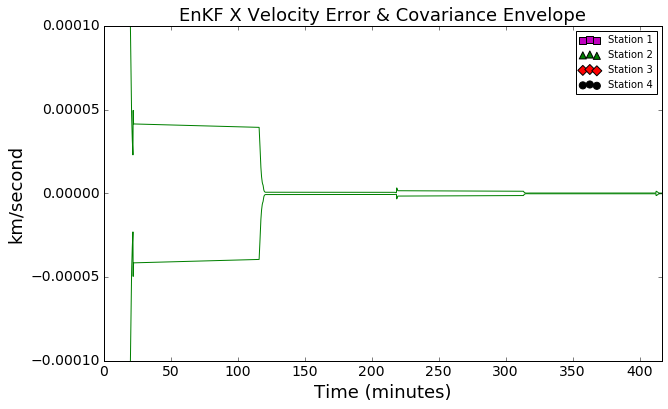

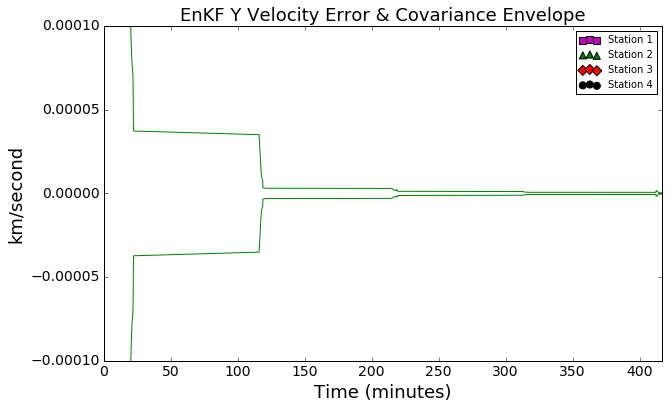

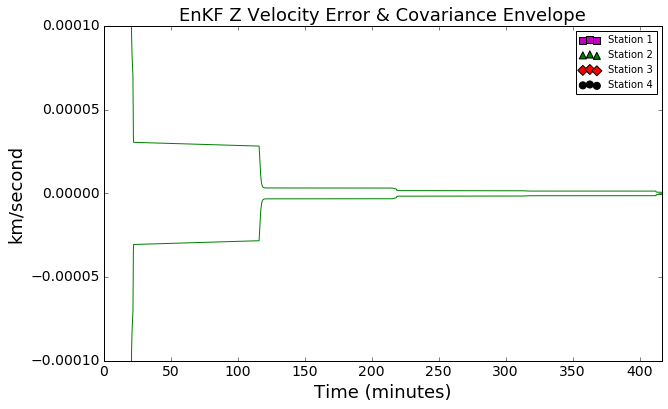

Velocity RMS:
X = 7.74492688792 km/second
Y = 4.8378541091 km/second
Z = 2.17180921812 km/second
Overall = 9.38645194735 km/s


In [24]:

#Generate Plots for Analysis

x_range = .005
y_range = .05
z_range = .05

xv_range = 1e-4
yv_range = 1e-4
zv_range = 1e-4

times = measurement_array[:, 0]

saveFig_bool = True


filter_functions.calc_display_results(post_fit_list_EnKF, measurement_array, R, meas_type, stop_index, saveFig_bool,\
                                     time_str)

filter_functions.plot_error_covar_xref(P_list_EnKF, X_mean_updated_list_EnKF, \
                      truth_xyz, true_density_array, x_range, y_range, z_range, xv_range, yv_range, zv_range,\
                      measurement_array, times, stop_index, saveFig_bool, time_str)


In [36]:
np.mean(est_density_array[:stop_index] - true_density_array[:stop_index])